# Setup

In [1]:
import pandas as pd
import os
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Loading the data

In [2]:
#Get route of the path
current_path = os.getcwd()
aux_curr_path = current_path
project_path = aux_curr_path.replace('/notebooks', '')
dataset_path = "dataset/CEE_DATA.arff"
dataset_path = os.path.join(project_path, dataset_path)

data, meta = arff.loadarff(dataset_path)

df = pd.DataFrame(data)
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x) #Encoding from byte to string 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Performance           666 non-null    object
 1   Gender                666 non-null    object
 2   Caste                 666 non-null    object
 3   coaching              666 non-null    object
 4   time                  666 non-null    object
 5   Class_ten_education   666 non-null    object
 6   twelve_education      666 non-null    object
 7   medium                666 non-null    object
 8   Class_ X_Percentage   666 non-null    object
 9   Class_XII_Percentage  666 non-null    object
 10  Father_occupation     666 non-null    object
 11  Mother_occupation     666 non-null    object
dtypes: object(12)
memory usage: 62.6+ KB


<Axes: title={'center': 'Relationship between Performance'}>

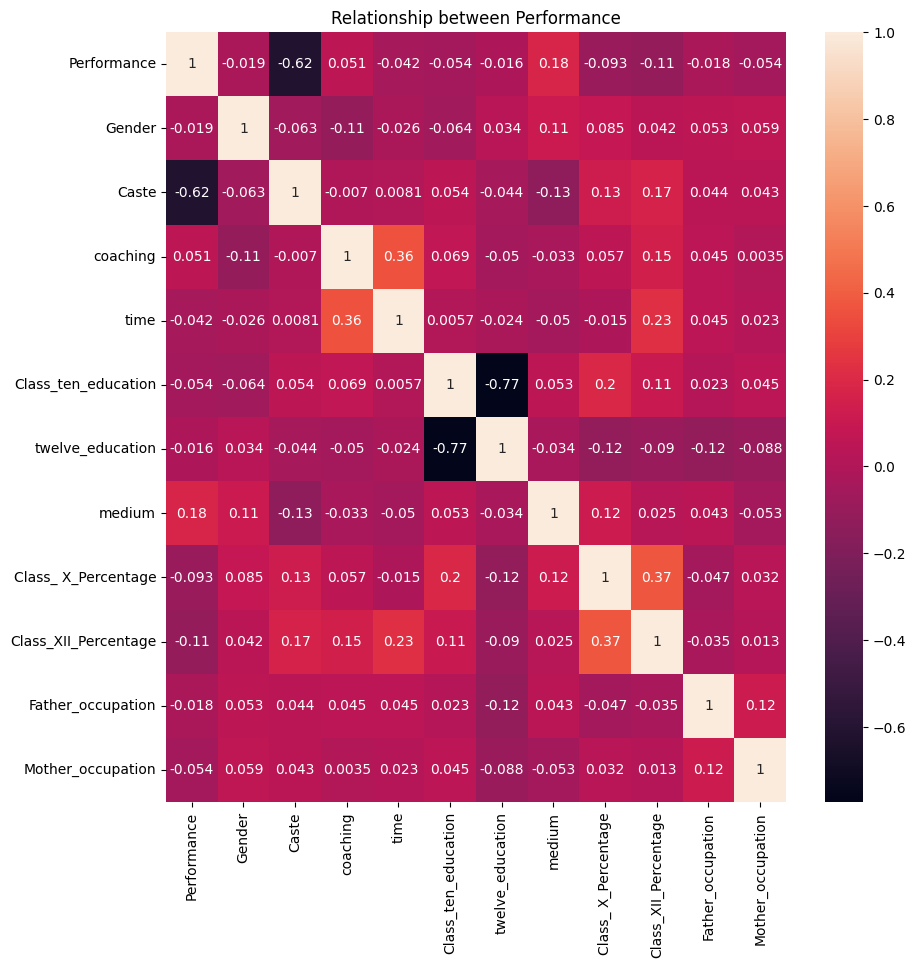

In [3]:
# Looking at the correlations
df_ordinal= df.copy()

cat_encoder= LabelEncoder()
lista_colmuns= [col for col in df_ordinal.columns]
for col in lista_colmuns:
  df_ordinal[col]=cat_encoder.fit_transform(df_ordinal[col])

corr_matrix=df_ordinal.corr()
plt.figure(figsize=(10,10))
plt.title(f'Relationship between Performance')
sns.heatmap(corr_matrix,annot=True)

            #0 : Average -  157
            #1 : Excellent - 101
            #2 : Good - 210
            #3 : Very Good - 198

Performance
Good         210
Vg           198
Average      157
Excellent    101
Name: count, dtype: int64


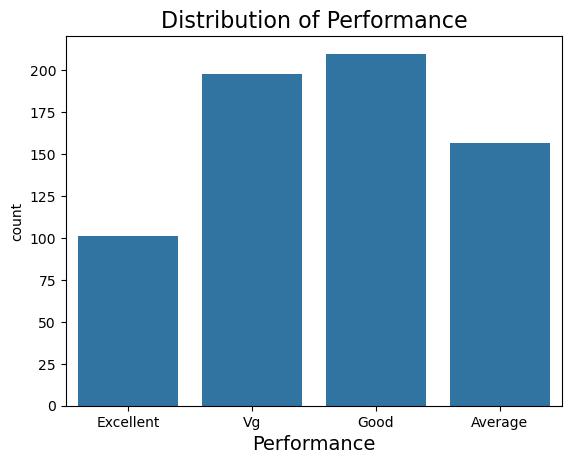

In [8]:
ax = sns.countplot(data=df, x="Performance")  
plt.title(f'Distribution of {"Performance"}', fontsize=16)
plt.xlabel("Performance", fontsize=14)

print(df["Performance"].value_counts())

# New Preprocessing and Feature Engineering

In [32]:
from imblearn.over_sampling import SMOTE
y = df['Performance']
X = df.drop('Performance', axis=1)
occupation_counts = X.groupby(['Gender', 'Father_occupation']).size().unstack(fill_value=0)
occupation_proportions = occupation_counts.div(occupation_counts.sum(axis=1), axis=0)
occupation_proportions.columns = [f'occupation_prop_{col}' for col in occupation_proportions.columns]
X = X.join(occupation_proportions, on='Gender')
X['Caste_Gender'] = X['Caste'] + '_' + X['Gender']
X['father_occupation_count'] = X.groupby('Father_occupation')['Father_occupation'].transform('count')
X['mother_occupation_count'] = X.groupby('Mother_occupation')['Mother_occupation'].transform('count')

X = pd.get_dummies(X, drop_first=True)
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

#Correlations
correlation_matrix = X.corr()
threshold = 0.69
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:  
            colname = correlation_matrix.columns[i]  
            to_drop.add(colname)
X = X.drop(columns=to_drop)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

y_df = y.values.reshape(-1, 1)  
enc_OneHot = OneHotEncoder()
y_OneHot = enc_OneHot.fit_transform(y_df).toarray()


ord_enc = LabelEncoder()
y_Label = ord_enc.fit_transform(y)

# Splitting the dataset

In [33]:
#Split the dataset for y_Label
X_train, X_test, y_train_OneHot, y_test_OneHot = train_test_split(X, y_OneHot, test_size=0.3, random_state=42)

#Split the dataset for y_Label
X_train, X_test, y_train_Label, y_test_Label = train_test_split(X, y_Label, test_size=0.3, random_state=42)

In [34]:

Experiments = [
    (
        "Random Forest n_estimators=100", 
        RandomForestClassifier(class_weight="balanced"),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),

    (
        "XGBoost",
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),
    
    (
         "Multinomial Logistic Regression",
        LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200),
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    ),
    
     (
        "K-Nearest Neighbors",
        KNeighborsClassifier(n_neighbors=5),
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    ),
    
    (
        "MLP",
        MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam'),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),
    
    (
        "Support Vector Classifier",
        SVC(kernel='linear', probability=True),  
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    )
    
    
]


In [35]:
results_per_model = []

for model_name, model, train_set, test_set in Experiments:
    X_train = train_set[0] #get Xtrain from the list models
    y_train = train_set[1] #get y_train from list models
    X_test = test_set[0]    #get x_test from list models 
    y_test = test_set[1]   #get y_test from list models
    
    model.fit(X_train, y_train)  #train the current model
    y_pred = model.predict(X_test) #make predictions 
    report = classification_report(y_test, y_pred, output_dict=True) #make a dict of the classification report
    
    
    results_per_model.append(report) #add the previus dict to a list

/Users/iossifpalli/Documents/GitHub/MLOps_Team_33/MLOps_Team_33/virtual_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iossifpalli/Documents/GitHub/MLOps_Team_33/MLOps_Team_33/virtual_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:52:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/iossifpalli/Documents/GitHub/MLOps_Team_33/MLOps_Team_33/virtual_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


# Publish experiements to server 

In [36]:
mlflow.set_experiment("Student Performance Analysis Model")
mlflow.set_tracking_uri("http://3.84.228.208:5000")

for i, element in enumerate(Experiments):
    model_name = element[0]
    model = element[1]
    report = results_per_model[i]
    
    with mlflow.start_run(run_name=model_name):        
            mlflow.log_param("model", model_name)
            
            
            # -------------Class interpretation---------------- 
            #0 : Average
            #1 : Excellent
            #2 : Good
            #3 : Very Good

            #Metrics of class 0
            
            mlflow.log_metric('acurracy_class_0', report['0']['precision'])
            mlflow.log_metric('recall_class_0', report['0']['recall'])
            mlflow.log_metric('f1_class_0', report['0']['f1-score'])
            
            #Metrics of class 1
             
            mlflow.log_metric('acurracy_class_1', report['1']['precision'])
            mlflow.log_metric('recall_class_1', report['1']['recall'])
            mlflow.log_metric('f1_class_1', report['1']['f1-score'])
            
            #Metrics of class 2
            
            mlflow.log_metric('acurracy_class_2', report['2']['precision'])
            mlflow.log_metric('recall_class_2', report['2']['recall'])
            mlflow.log_metric('f1_class_2', report['2']['f1-score'])
            
            #Metrics of class 3
            
            mlflow.log_metric('acurracy_class_3', report['3']['precision'])
            mlflow.log_metric('recall_class_3', report['3']['recall'])
            mlflow.log_metric('f1_class_3', report['3']['f1-score'])
            
        
            if "XGB" in model_name:
                mlflow.xgboost.log_model(model, "model")
            else:
                mlflow.sklearn.log_model(model, "model") 

/Users/iossifpalli/Documents/GitHub/MLOps_Team_33/MLOps_Team_33/virtual_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:16: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/iossifpalli/Documents/GitHub/MLOps_Team_33/MLOps_Team_33/virtual_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/10/19 15:53:00 WARNING mlflo